Loaded mask dimensions: (3072, 4352) with data type: uint8
Unique values after normalization: [  0 255]
Total contours detected: 902


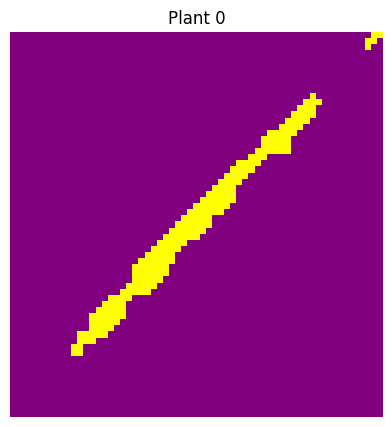

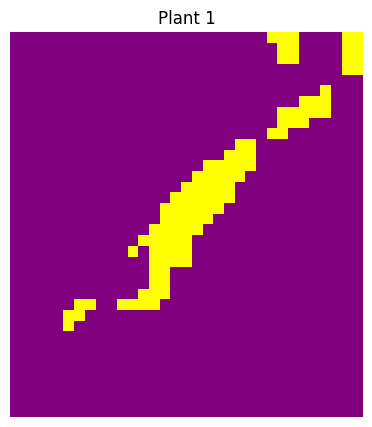

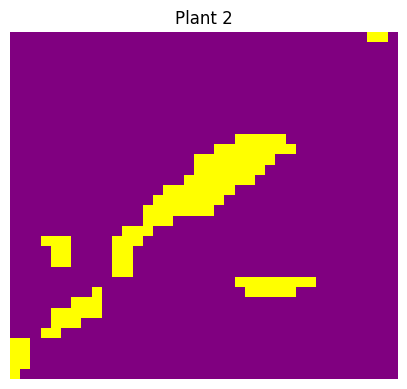

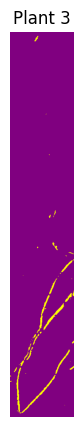

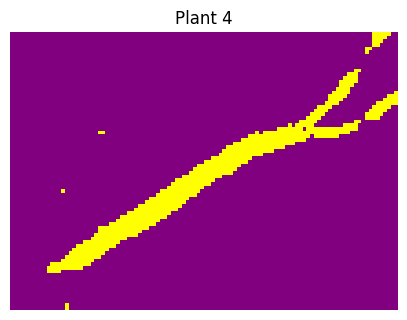

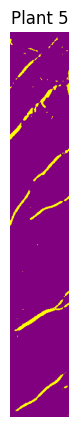

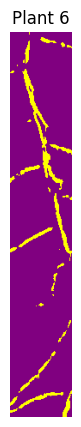

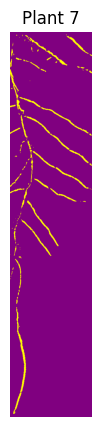

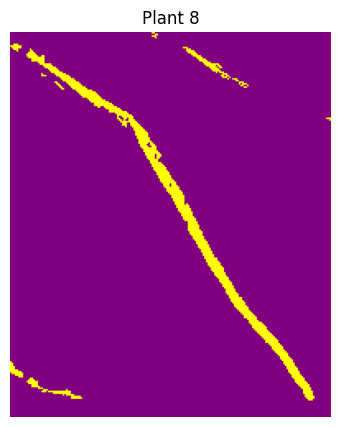

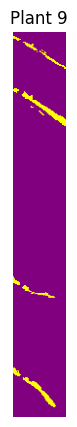

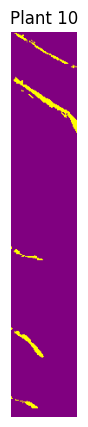

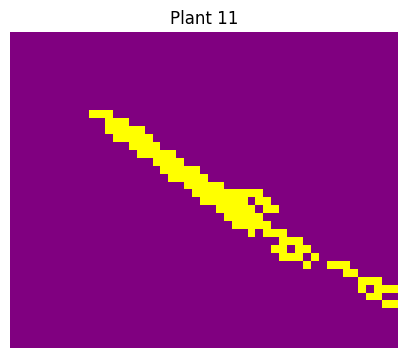

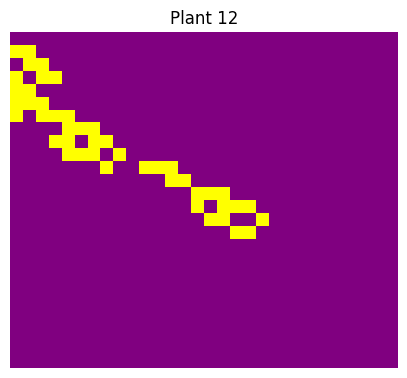

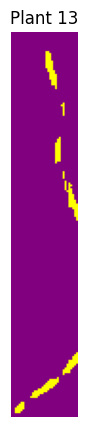

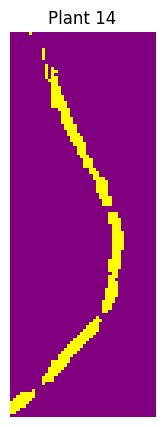

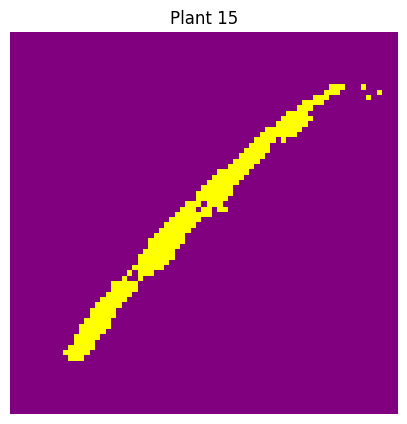

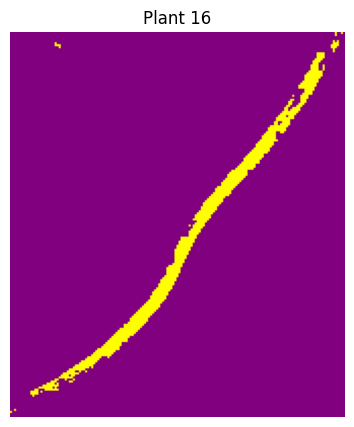

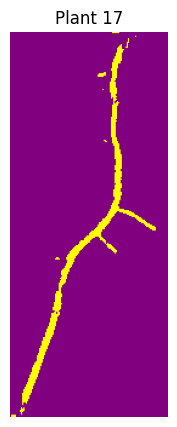

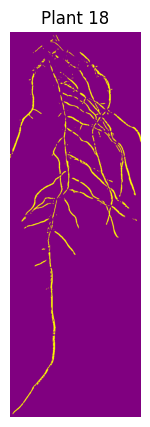

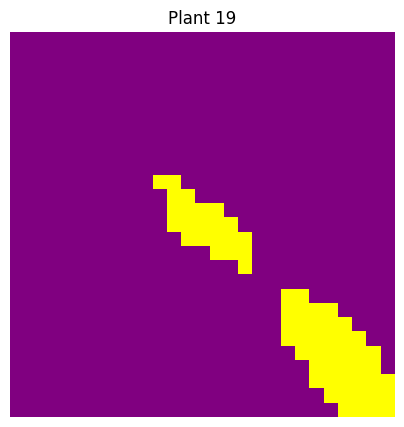

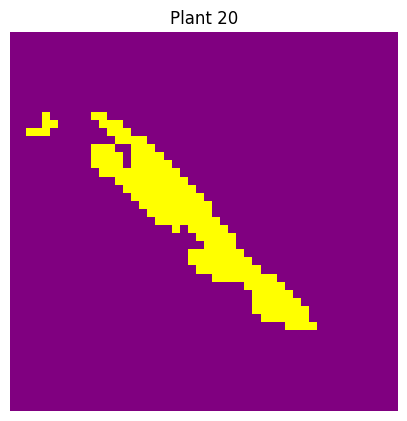

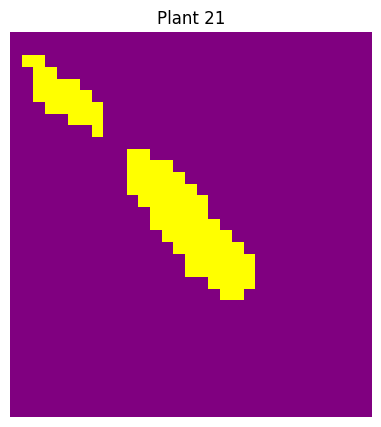

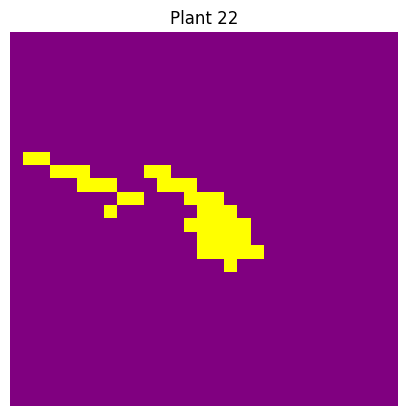

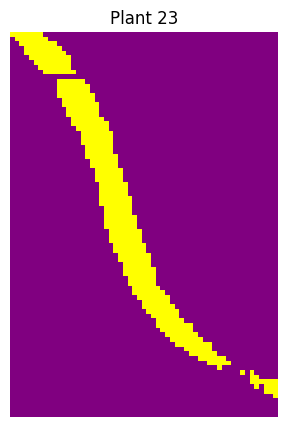

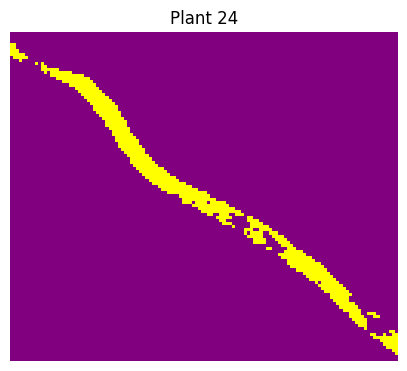

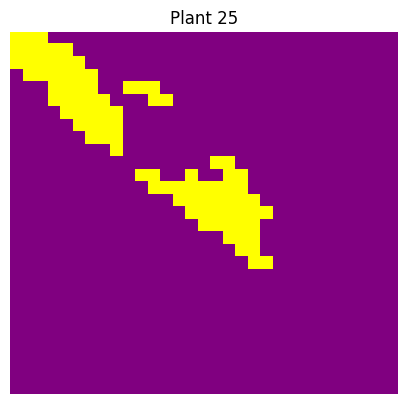

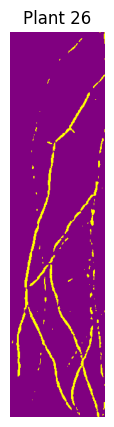

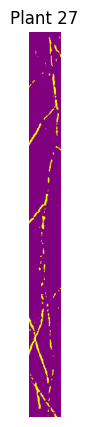

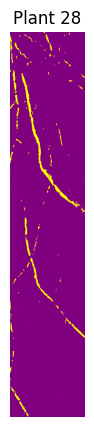

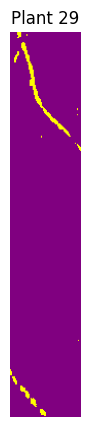

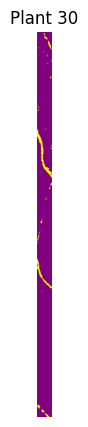

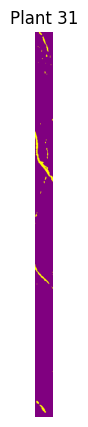

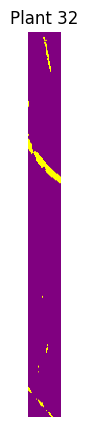

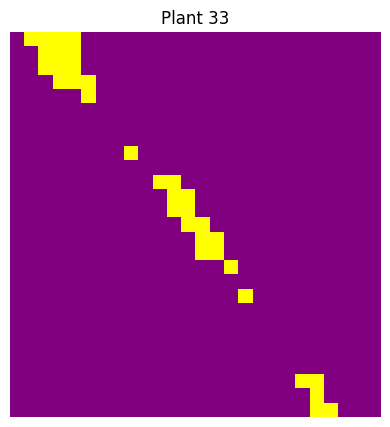

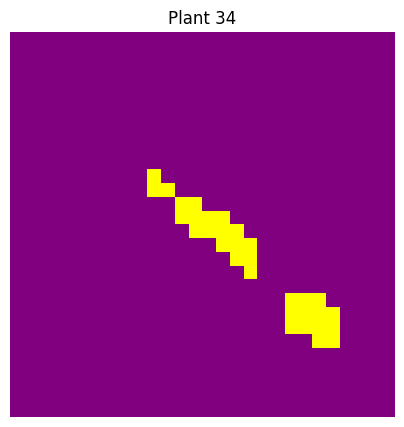

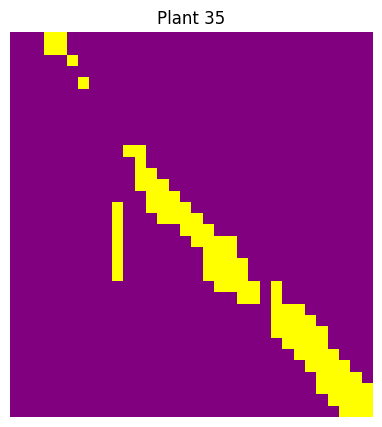

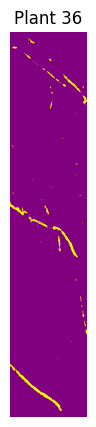

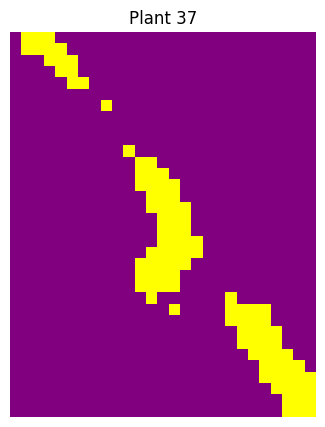

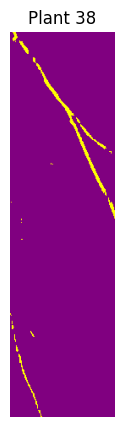

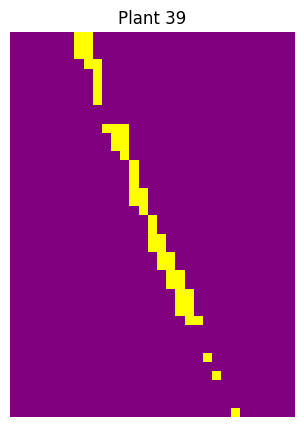

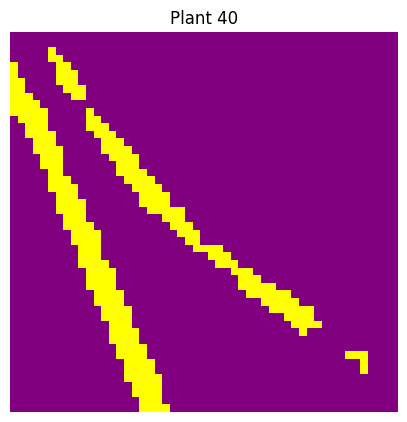

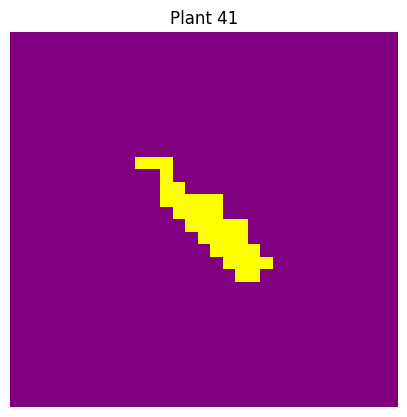

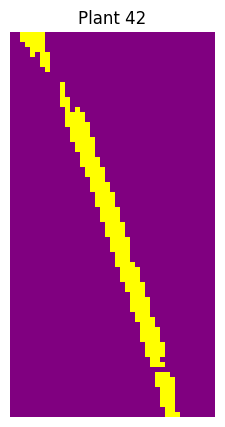

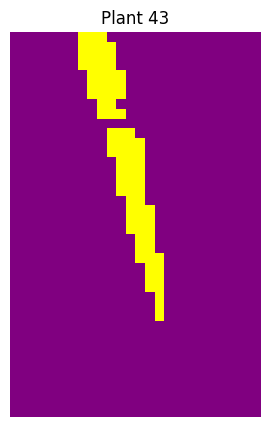

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
def process_mask_regions(mask_file, pad=10):
 
    """
    Process a binary mask image to identify white areas,
    create bounding rectangles around these regions, crop them with additional padding,
    and finally display each cropped region with custom colors:
    a purple background ([128, 0, 128]) with yellow ([255, 255, 0]) for the white regions.
 
    Parameters:
        mask_file (str): Path to the mask image file (e.g., TIFF).
        pad (int): Extra margin to add around the detected regions.
 
    """
    # Load the mask image in unchanged mode.
    mask_img = cv2.imread(mask_file, cv2.IMREAD_UNCHANGED)
 
    if mask_img is None:
 
        raise FileNotFoundError(f"Unable to load the mask image from: {mask_file}")
 
    # Output some debug info about the loaded mask.
    print("Loaded mask dimensions:", mask_img.shape, "with data type:", mask_img.dtype)
 
    # Normalize the image to ensure binary values (0 and 255).
    norm_mask = np.where(mask_img > 0, 255, 0).astype(np.uint8)
 
    print("Unique values after normalization:", np.unique(norm_mask))
 
    # Detect contours in the binary mask.
    detected_contours, _ = cv2.findContours(norm_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
    print("Total contours detected:", len(detected_contours))
 
    if not detected_contours:
 
        print("No white regions were found in the mask.")
 
        return
 
    # Create a list of bounding rectangles from the contours.
    rectangles = []
 
    for cnt in detected_contours:
 
        x, y, width, height = cv2.boundingRect(cnt)
 
        if width > 5 and height > 5:  # Ignore small artifacts
 
            rectangles.append((x, y, x + width, y + height))
 
    # Merge rectangles that overlap.
    def merge_rectangles(rects):
 
        merged = []
 
        for rect in sorted(rects, key=lambda r: r[0]):  # sort by x-coordinate
 
            if not merged:
 
                merged.append(rect)
 
            else:
 
                last_rect = merged[-1]
 
                # Check for any overlap with the previous rectangle.
 
                if rect[0] <= last_rect[2] and rect[1] <= last_rect[3]:
 
                    merged[-1] = (min(last_rect[0], rect[0]),
                                  min(last_rect[1], rect[1]),
                                  max(last_rect[2], rect[2]),
                                  max(last_rect[3], rect[3]))
 
                else:
 
                    merged.append(rect)
 
        return merged
 
    combined_rectangles = merge_rectangles(rectangles)
 
    # Retrieve overall mask dimensions.
    mask_height, mask_width = norm_mask.shape
 
    # Process each detected region.
    for i, (x1, y1, x2, y2) in enumerate(combined_rectangles):
 
        # Apply padding while staying within image bounds.
        x1_pad = max(0, x1 - pad)
        y1_pad = max(0, y1 - pad)
        x2_pad = min(mask_width, x2 + pad)
        y2_pad = min(mask_height, y2 + pad)
 
        # Create a temporary mask for the current region and crop it.
        region_temp = np.zeros_like(norm_mask)
 
        region_temp[y1_pad:y2_pad, x1_pad:x2_pad] = norm_mask[y1_pad:y2_pad, x1_pad:x2_pad]
 
        cropped = region_temp[y1_pad:y2_pad, x1_pad:x2_pad]
 
        # Prepare an RGB image with a purple background.
        custom_img = np.full((cropped.shape[0], cropped.shape[1], 3), (128, 0, 128), dtype=np.uint8)
 
        # Overwrite with yellow where the region is present.
        custom_img[cropped > 0] = (255, 255, 0)
 
        # Display the resulting colored crop.
        plt.figure(figsize=(5, 5))
        plt.imshow(custom_img)
        plt.title(f"Plant {i}")
        plt.axis('off')
        plt.show()
 
# Example usage:
mask_file_path = r"/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/task5_test_image_prediction_celine_231265.png"
process_mask_regions(mask_file_path, pad=10)